In [75]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt
import random

import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality
from cornac.data.text import BaseTokenizer
from cornac.models import CTR

In [2]:
mind = pd.read_csv('dataset/mind_algorithm_test.csv')
mind['story'] = mind['story'].astype('int')
mind.head(2)

,user_id,item_id,rating,date,category,url,text,entities,sentiment,complexity,publication_date,entities_base,enriched_entities,story
0,U13740,N55189,1,2019-10-15,tv,https://assets.msn.com/labs/mind/AAIORni.html,"We’d like to solve the puzzle, Pat: Blair Davi...","[{'text': 'Cardiff', 'alternative': ['Cardiff'...",0.091856,62.17,1.571098e+12,"[{'text': 'Pat', 'start_char': 31, 'end_char':...","[{'text': 'Cardiff', 'alternative': ['Cardiff'...",766
1,U13740,N42782,1,2019-10-19,sports,https://assets.msn.com/labs/mind/AAJ1mE9.html,The Yankees forced a Game 6 on Friday as it to...,"[{'text': 'second', 'alternative': ['second'],...",0.028105,73.92,1.571443e+12,"[{'text': 'Yankees', 'start_char': 4, 'end_cha...","[{'text': 'second', 'alternative': ['second'],...",444


In [3]:
# pre-process data to initialize ctr model
mind_feedback = mind.loc[:, ['user_id','item_id','rating']]
# feedback = cornac.data.Dataset.from_uir(mind_feedback.itertuples(index=False))
feedback = mind_feedback.apply(lambda x: tuple(x), axis=1).values.tolist()
text = list(mind['text'])
item_ids = list(mind['item_id'])
# Instantiate a TextModality, it makes it convenient to work with text auxiliary information
item_text_modality = TextModality(
    corpus=text,
    ids=item_ids,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=8000,
    max_doc_freq=0.5,
)

# Define an evaluation method to split feedback into train and test sets
ratio_split = RatioSplit(
    data=feedback,
    test_size=0.2,
    exclude_unknowns=True,
    item_text=item_text_modality,
    verbose=False,
    seed=123,
    rating_threshold=0.5,
)

/Users/pigr/cornac/lib/python3.10/site-packages/cornac/data/dataset.py:361: UserWarning: 77 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/Users/pigr/cornac/lib/python3.10/site-packages/cornac/data/dataset.py:361: UserWarning: 3 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


## Implement different epochs

In [4]:
# Instantiate CTR model
# Vary epochs = {1, 25, 50, 100, 150, 200}
ctr_iter_1 = CTR(k=200, max_iter=1, lambda_v=0.01)
ctr_iter_25 = CTR(k=200, max_iter=25, lambda_v=0.01)
ctr_iter_50 = CTR(k=200, max_iter=50, lambda_v=0.01)
ctr_iter_100 = CTR(k=200, max_iter=100, lambda_v=0.01)
ctr_iter_150 = CTR(k=200, max_iter=150, lambda_v=0.01)
ctr_iter_200 = CTR(k=200, max_iter=200, lambda_v=0.01)

# Use Recall@200 for evaluation
rec_200 = cornac.metrics.Recall(k=200)

# Put everything together into an experiment and run it
cornac.Experiment(eval_method=ratio_split,
                  models=[ctr_iter_1, ctr_iter_25, ctr_iter_50, ctr_iter_100, ctr_iter_150, ctr_iter_200],
                  metrics=[rec_200]).run()

  0%|          | 0/1 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/25 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/150 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/200 [00:00<?, ?it/s]

Learning completed!

TEST:
...
    | Recall@200 | Train (s) | Test (s)
--- + ---------- + --------- + --------
CTR |     0.1275 |   13.1068 |   0.2257
CTR |     0.1376 |  215.8241 |   0.1788
CTR |     0.1467 |  394.2349 |   0.1539
CTR |     0.1443 |  827.0982 |   0.1885
CTR |     0.1384 | 1164.2587 |   0.1522
CTR |     0.1061 |  972.4349 |   0.0826



In [7]:
ctr_iter_250 = CTR(k=200, max_iter=250, lambda_v=0.01)
ctr_iter_300 = CTR(k=200, max_iter=300, lambda_v=0.01)

# Use Recall@200 for evaluation
rec_200 = cornac.metrics.Recall(k=200)

# Put everything together into an experiment and run it
cornac.Experiment(eval_method=ratio_split,
                  models=[ctr_iter_250, ctr_iter_300],
                  metrics=[rec_200]).run()

  0%|          | 0/250 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/300 [00:00<?, ?it/s]

Learning completed!

TEST:
...
    | Recall@200 | Train (s) | Test (s)
--- + ---------- + --------- + --------
CTR |     0.1157 | 1187.5574 |   0.1192
CTR |     0.1228 | 1144.1686 |   0.0900



In [5]:
# This class is just convenient for getting two lists as inputs of the calibration metric computation
class Retrieval:

    def __init__(self, model, data, UIDX, feature) -> None:
        self.model = model
        self.data = data
        self.UIDX = UIDX
        self.feature = feature # 'category', 'story', ...

    def convert_idx_id(self):
        # conversion between idx and id
        rating_mat = self.model.train_set.matrix
        user_id2idx = self.model.train_set.uid_map
        user_idx2id = list(self.model.train_set.user_ids)
        item_id2idx = self.model.train_set.iid_map
        item_idx2id = list(self.model.train_set.item_ids)

        return user_id2idx, user_idx2id, item_id2idx, item_idx2id

    def get_recy(self):
        recommendations_idx = self.model.rank(self.UIDX)[0]
        item_idx2id = self.convert_idx_id()[3]
        recommendations = [item_idx2id[idx] for idx in recommendations_idx]
        dict = self.data.set_index(['item_id'])[self.feature].to_dict()
        recy_list = [dict.get(item) for item in recommendations]

        return recy_list

    def get_history(self):
        dict = self.data.set_index(['item_id'])[self.feature].to_dict()
        user_id = self.convert_idx_id()[1][self.UIDX]
        history = list(self.data[self.data['user_id']==user_id]['item_id'])
        user_history = [dict.get(item) for item in history]

        return user_history


In [27]:
# Compute diversity metric
class Diversity:
    """Diversity Metric

    Parameters
    ----------
    k: int or list, optional, default: -1 (all)
    The number of items in the top@k list.
    If None, all items will be considered.

    list1: list
    a list of features

    list2: list
    a list of features

    Returns
    ----------
    A number: the result of the metric

    """

    def __init__(self, list1, list2, k=-1):
        self.list1 = list1[:k]
        self.list2 = list2[:k]

    def compute_distr(self, items):
        """Compute the categorical distribution from a given list of Items.

        Parameters
        ----------
        items: list of features

        Returns
        -------
        dist [dict]: dictionary of feature distributions

        """

        distr = {}

        for index, item in enumerate(items):
            try:
                count = distr.get(item, 0.)
                distr[item] = count + 1
            except:
                continue

        # normalize the summed up probability, so it sums up to 1
        total_n = sum(list(distr.values()))
        for item, count in distr.items():
            distr[item] = count / total_n

        return distr

    def compute_kl_divergence(self, s, q, alpha=0.001):
        """
          params: s, q - two distributions (dict)

          KL (p || q), the lower the better.
          alpha is not really a tuning parameter, it's just there to make the
          computation more numerically stable.
        """
        try:
          assert 0.99 <= sum(s.values()) <= 1.01
          assert 0.99 <= sum(q.values()) <= 1.01
        except AssertionError:
          print("Assertion Error")
          pass
        kl_div = 0.
        ss = []
        qq = []
        merged_dic = self.opt_merge_max_mappings(s, q)
        for key in sorted(merged_dic.keys()):
          q_score = q.get(key, 0.)
          s_score = s.get(key, 0.)
          ss.append((1 - alpha) * s_score + alpha * q_score) # avoid misspecified metrics
          qq.append((1 - alpha) * q_score + alpha * s_score) # avoid misspecified metrics
        kl = entropy(ss, qq, base=2)
        return kl

    def opt_merge_max_mappings(self, dict1, dict2):
        """ Merges two dictionaries based on the largest value in a given mapping.
        Parameters
        ----------
        dict1 : Dict[Any, Comparable]
        dict2 : Dict[Any, Comparable]
        Returns
        -------
        Dict[Any, Comparable]
            The merged dictionary
        """
        # we will iterate over `other` to populate `merged`
        merged, other = (dict1, dict2) if len(dict1) > len(dict2) else (dict2, dict1)
        merged = dict(merged)
        for key in other:
          if key not in merged or other[key] > merged[key]:
            merged[key] = other[key]
        return merged

    def compute(self):
        s = self.compute_distr(self.list1)
        q = self.compute_distr(self.list2)

        return self.compute_kl_divergence(s, q)

In [90]:
# 'Diversity Metric'
# Compute the average result
models=[ctr_iter_1, ctr_iter_25, ctr_iter_50, ctr_iter_100,
        ctr_iter_150, ctr_iter_200, ctr_iter_250, ctr_iter_300]
def get_metric_result_ca(feature_name='category'):
    avg_result = []
    for model in models: # for a specific model
        result = []
        for i in range(len(set(mind['user_id']))):  # get the average result for all users
            r = Retrieval(model=model, data=mind, UIDX=i, feature=feature_name)
            recommendation = r.get_recy()
            history = r.get_history()
            d = Diversity(history, recommendation, k=200)
            result.append(d.compute())
        avg_result.append(np.mean(result))
    return avg_result

user_list = list(np.arange((len(set(mind['user_id'])))))
def get_metric_result_frag(feature_name='story'):
    avg_result = []
    for model in models:
        result = []
        i = 0
        while i <= 1000:
            # shuffle
            user_pair = random.sample(user_list, 2)
            r0 = Retrieval(model=model, data=mind, UIDX=user_pair[0], feature=feature_name)
            r1 = Retrieval(model=model, data=mind, UIDX=user_pair[1], feature=feature_name)
            recommendation0 = r0.get_recy()
            recommendation1 = r1.get_recy()
            d = Diversity(recommendation0, recommendation1, k=200)
            result.append(d.compute())
            i += 1
        avg_result.append(np.mean(result))
    return avg_result

calibration_result = get_metric_result_ca('category')
fragmentation_result = get_metric_result_frag('story')
recall_result = [0.1275, 0.1376, 0.1467, 0.1443,  0.1384, 0.1061, 0.1157, 0.1228]

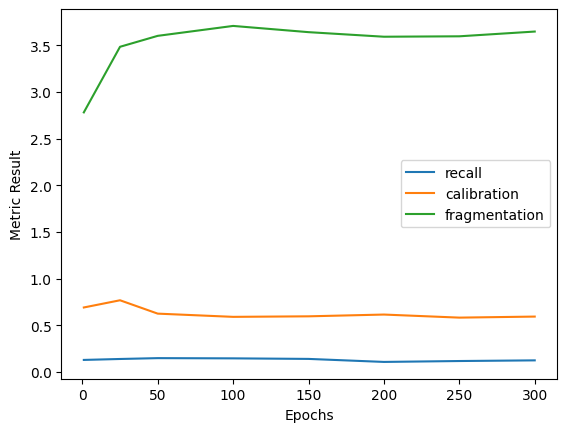

In [91]:
# Plot
x = [1, 25, 50, 100, 150, 200, 250, 300]
plt.plot(x, recall_result, label='recall')
plt.plot(x, calibration_result, label='calibration')
plt.plot(x, fragmentation_result, label='fragmentation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Metric Result')
plt.show()

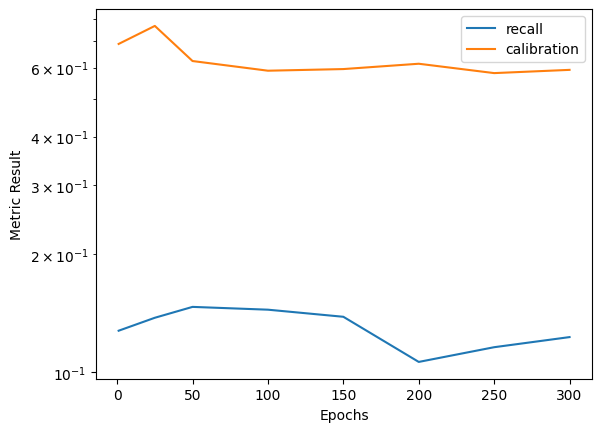

In [92]:
plt.plot(x, recall_result, label='recall')
plt.plot(x, calibration_result, label='calibration')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Metric Result')
plt.yscale('log')
plt.show()

## Implement different numbers of recommendations (@TOPK)

In [31]:
# Instantiate CTR model
# Vary @TOPK = {20, 40, 60, 80, 100, 120, 140, 160, 180, 200}
ctr = CTR(k=200, max_iter=50, lambda_v=0.01)

# Use Recall@TOPK for evaluation
rec_20 = cornac.metrics.Recall(k=20)
rec_40 = cornac.metrics.Recall(k=40)
rec_60 = cornac.metrics.Recall(k=60)
rec_80 = cornac.metrics.Recall(k=80)
rec_100 = cornac.metrics.Recall(k=100)
rec_120 = cornac.metrics.Recall(k=120)
rec_140 = cornac.metrics.Recall(k=140)
rec_160 = cornac.metrics.Recall(k=160)
rec_180 = cornac.metrics.Recall(k=180)
rec_200 = cornac.metrics.Recall(k=200)

# Put everything together into an experiment and run it
cornac.Experiment(eval_method=ratio_split,
                  models=[ctr],
                  metrics=[rec_20, rec_40, rec_60, rec_80,
                           rec_100, rec_120, rec_140, rec_160,
                           rec_180, rec_200]).run()

  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

TEST:
...
    | Recall@100 | Recall@120 | Recall@140 | Recall@160 | Recall@180 | Recall@20 | Recall@200 | Recall@40 | Recall@60 | Recall@80 | Train (s) | Test (s)
--- + ---------- + ---------- + ---------- + ---------- + ---------- + --------- + ---------- + --------- + --------- + --------- + --------- + --------
CTR |     0.0937 |     0.1109 |     0.1201 |     0.1319 |     0.1376 |    0.0103 |     0.1569 |    0.0333 |    0.0430 |    0.0623 |  239.0392 |   0.2166



In [120]:
TOPK = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
def get_metric_result_ca(feature_name):
    avg_result = np.ones(10)
    for i in range(len(set(mind['user_id']))): # for each user
        result = []
        r = Retrieval(model=ctr, data=mind, UIDX=i, feature=feature_name)
        recommendation = r.get_recy()
        history = r.get_history()
        for k in TOPK:
            d = Diversity(history, recommendation, k=k)
            result.append(d.compute())
        avg_result = np.vstack((avg_result, result))  # [[1, 1, 1],
                                                       # [2, 2, 2]]
    avg_result = np.delete(avg_result, 0, axis=0)
    return np.average(avg_result, axis=0)

# user_list = list(np.arange((len(set(mind['user_id'])))))
def get_metric_result_frag(feature_name):
    avg_result = np.ones(10)
    i = 0
    while i <= 1000:
        # shuffle
        user_pair = random.sample(user_list, 2)
        r0 = Retrieval(model=ctr, data=mind, UIDX=user_pair[0], feature=feature_name)
        r1 = Retrieval(model=ctr, data=mind, UIDX=user_pair[1], feature=feature_name)
        recommendation0 = r0.get_recy()
        recommendation1 = r1.get_recy()
        result = []
        for k in TOPK:
            d = Diversity(recommendation0, recommendation1, k=k)
            result.append(d.compute())
        i += 1
        avg_result = np.vstack((avg_result, result))
    avg_result = np.delete(avg_result, 0, axis=0)
    return np.average(avg_result, axis=0)

calibration_result = get_metric_result_ca('category')
fragmentation_result = get_metric_result_frag('story')
recall_result = [0.0103, 0.0333, 0.00430, 0.0623, 0.0937, 0.1109, 0.1201, 0.1319, 0.1376, 0.1569]

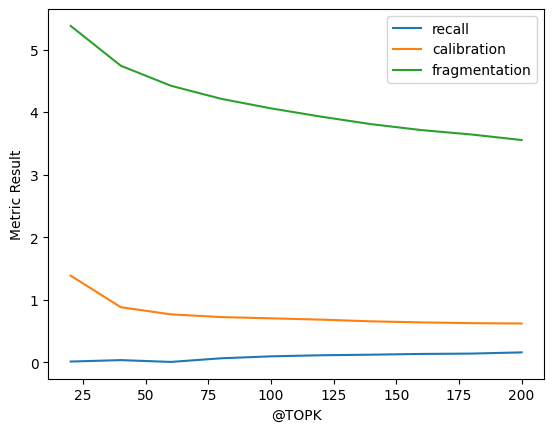

In [121]:
# Plot
x = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
plt.plot(x, recall_result, label='recall')
plt.plot(x, calibration_result, label='calibration')
plt.plot(x, fragmentation_result, label='fragmentation')
plt.legend(loc='best')
plt.xlabel('@TOPK')
plt.ylabel('Metric Result')
plt.show()

## Implement different values of lambda_v

In [58]:
# Instantiate CTR model
# Vary lambda_v={0.01, 0.1, 1, 10, 100, 1000, 10000}
lambda_v = [0.01, 0.1, 1, 10, 100, 1000, 10000]
ctr_lambda_v = [CTR(k=200, max_iter=50, lambda_v=v) for v in lambda_v]
def run_ctr_v(ctr_lambda_v):
    # Use Recall@300 for evaluation
    rec_200 = cornac.metrics.Recall(k=200)
    # Put everything together into an experiment and run it
    cornac.Experiment(eval_method=ratio_split,
                      models=[ctr_lambda_v],
                      metrics=[rec_200]).run()

for ctr_v in ctr_lambda_v:
    run_ctr_v(ctr_v)

  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

TEST:
...
    | Recall@200 | Train (s) | Test (s)
--- + ---------- + --------- + --------
CTR |     0.1713 |  203.8582 |   0.1126



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

TEST:
...
    | Recall@200 | Train (s) | Test (s)
--- + ---------- + --------- + --------
CTR |     0.1556 |  244.5030 |   0.1167



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

TEST:
...
    | Recall@200 | Train (s) | Test (s)
--- + ---------- + --------- + --------
CTR |     0.1604 |  214.2513 |   0.1124



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

TEST:
...
    | Recall@200 | Train (s) | Test (s)
--- + ---------- + --------- + --------
CTR |     0.1810 |  230.6353 |   0.1388



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

TEST:
...
    | Recall@200 | Train (s) | Test (s)
--- + ---------- + --------- + --------
CTR |     0.1998 |  210.5988 |   0.1973



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

TEST:
...
    | Recall@200 | Train (s) | Test (s)
--- + ---------- + --------- + --------
CTR |     0.1467 |  236.9315 |   0.1290



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

TEST:
...
    | Recall@200 | Train (s) | Test (s)
--- + ---------- + --------- + --------
CTR |     0.1395 |  205.1779 |   0.1179



In [123]:
models = ctr_lambda_v
def get_metric_result_ca(feature_name='category'):
    avg_result = []
    for model in models: # for a specific model
        result = []
        for i in range(len(set(mind['user_id']))):  # get the average result for all users
            r = Retrieval(model=model, data=mind, UIDX=i, feature=feature_name)
            recommendation = r.get_recy()
            history = r.get_history()
            d = Diversity(history, recommendation, k=200)
            result.append(d.compute())
        avg_result.append(np.mean(result))
    return avg_result

user_list = list(np.arange((len(set(mind['user_id'])))))
def get_metric_result_frag(feature_name='story'):
    avg_result = []
    for model in models:
        result = []
        i = 0
        while i <= 1000:
            # shuffle
            user_pair = random.sample(user_list, 2)
            r0 = Retrieval(model=model, data=mind, UIDX=user_pair[0], feature=feature_name)
            r1 = Retrieval(model=model, data=mind, UIDX=user_pair[1], feature=feature_name)
            recommendation0 = r0.get_recy()
            recommendation1 = r1.get_recy()
            d = Diversity(recommendation0, recommendation1, k=200)
            result.append(d.compute())
            i += 1
        avg_result.append(np.mean(result))
    return avg_result

calibration_result = get_metric_result_ca('category')
fragmentation_result = get_metric_result_frag('story')
recall_result = [0.1713, 0.1556, 0.1604, 0.1810, 0.1998, 0.1467, 0.1395]

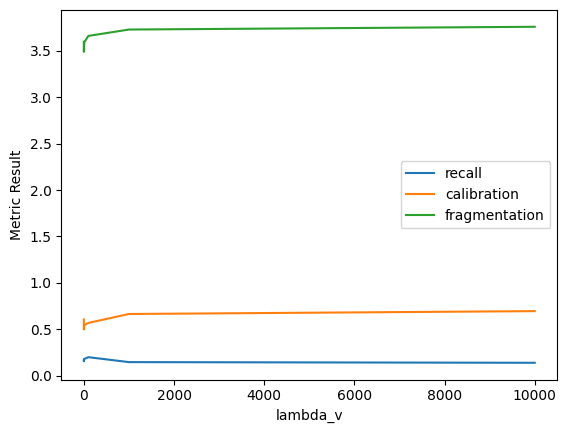

In [124]:
# Plot
x = [0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.plot(x, recall_result, label='recall')
plt.plot(x, calibration_result, label='calibration')
plt.plot(x, fragmentation_result, label='fragmentation')
plt.legend(loc='best')
plt.xlabel('lambda_v')
plt.ylabel('Metric Result')
plt.show()

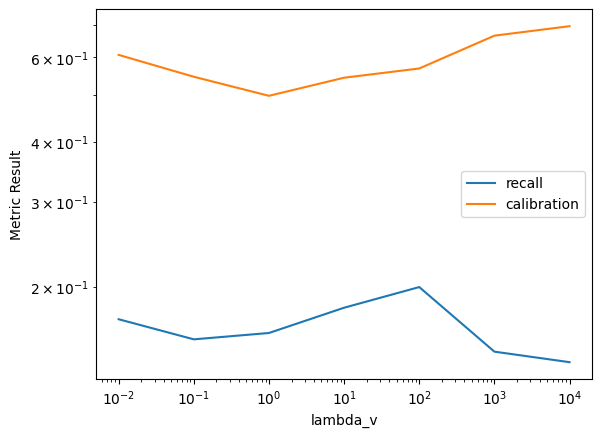

In [136]:
plt.plot(x, recall_result, label='recall')
plt.plot(x, calibration_result, label='calibration')
plt.legend(loc='best')
plt.xlabel('lambda_v')
plt.ylabel('Metric Result')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [126]:
np.argmax(calibration_result)

6

In [127]:
calibration_result

[0.6064907725036408,
 0.5462373015062867,
 0.49869031620570103,
 0.5437591071765483,
 0.5683195055050553,
 0.6648616837099105,
 0.6957276590459968]